In [3]:
import numpy as np
import cv2 as cv
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
cv.__version__

'4.5.1'

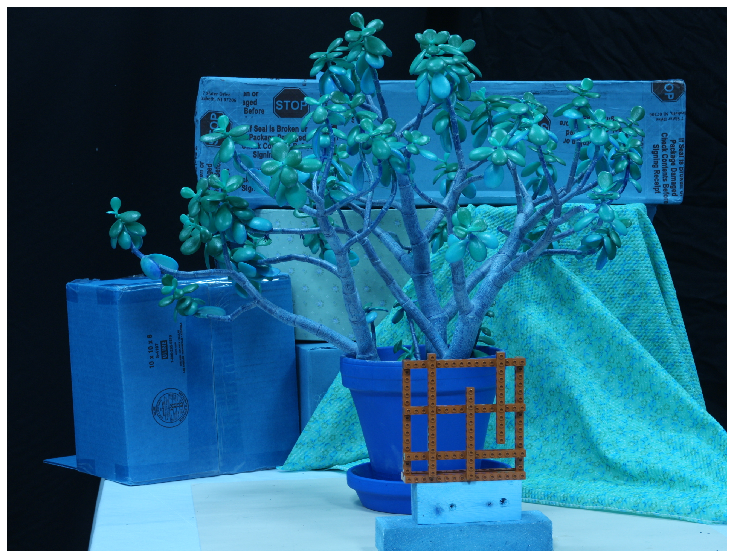

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))

fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)

imgL = cv.imread('data/Middlebury/Jadeplant-perfect/im0.png')
imgR = cv.imread('data/Middlebury/Jadeplant-perfect/im1.png')

plt.axis('off')

plt.imshow(imgL)
plt.show()

## Adds left padding

In [4]:
imgL = cv.copyMakeBorder(imgL,0,0,640,0,cv.BORDER_CONSTANT)
imgR = cv.copyMakeBorder(imgR,0,0,640,0,cv.BORDER_CONSTANT)

imgL[:1]

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 7, 15, 24],
        [ 8, 15, 24],
        [ 8, 16, 24]]], dtype=uint8)

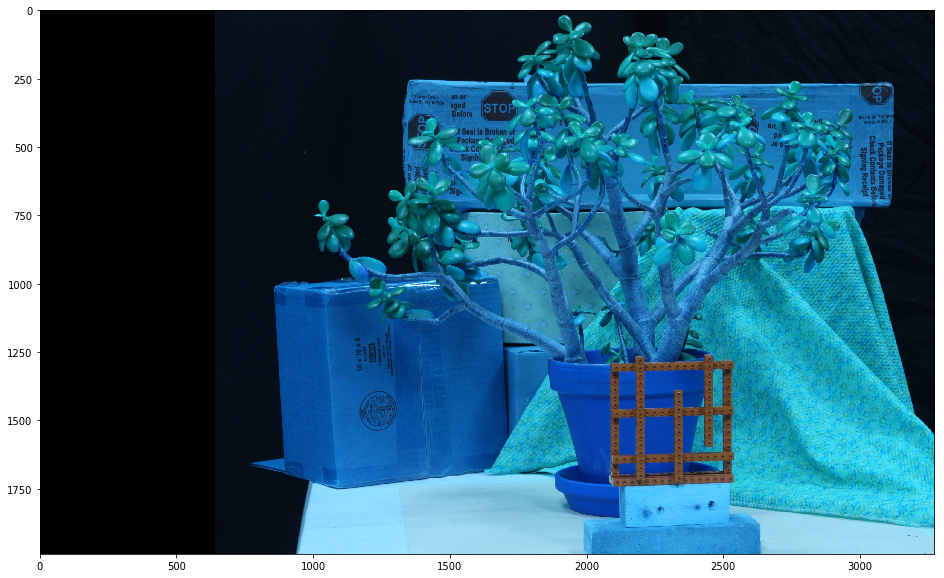

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(imgL)
plt.show()

## First test, using simple SGBM

computing disparity...


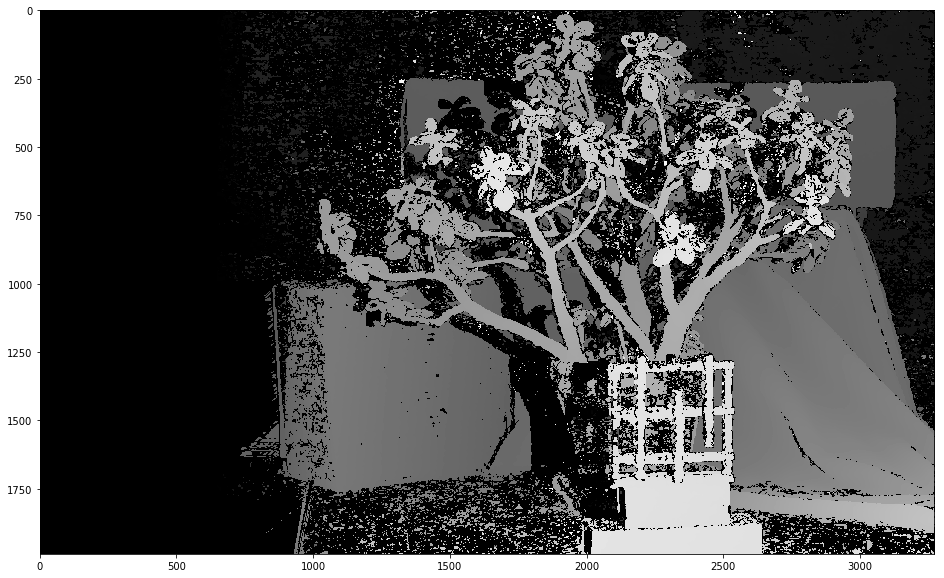

In [6]:
window_size = 5
min_disp = 0
num_disp = 640
stereo = cv.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 8,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 15,
    speckleWindowSize = 0,
    speckleRange = 2,
    mode=cv.STEREO_SGBM_MODE_SGBM
)

print('computing disparity...')
disp = stereo.compute(imgL, imgR)
norm_disp = (disp-min_disp)/num_disp

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(norm_disp,'gray')
plt.show()

## Second method using 'mode 3way' + disparity map post-filtering

In [7]:
window_size = 3
 
left_matcher = cv.StereoSGBM_create(
    minDisparity=0,
    numDisparities=640,             
    blockSize=5,
    P1=8 * 3 * window_size ** 2,    
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=2,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv.ximgproc.createRightMatcher(left_matcher)

In [8]:
print('computing disparity...')
displ = left_matcher.compute(imgL, imgR)
dispr = right_matcher.compute(imgR, imgL)
displ = np.int16(displ)
dispr = np.int16(dispr)

computing disparity...


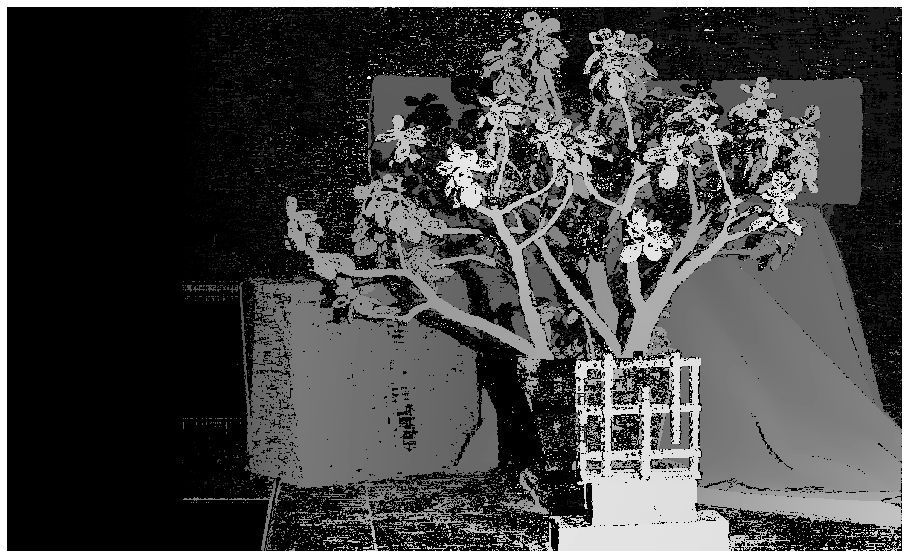

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.axis('off')

plt.imshow(displ,'gray')
plt.show()

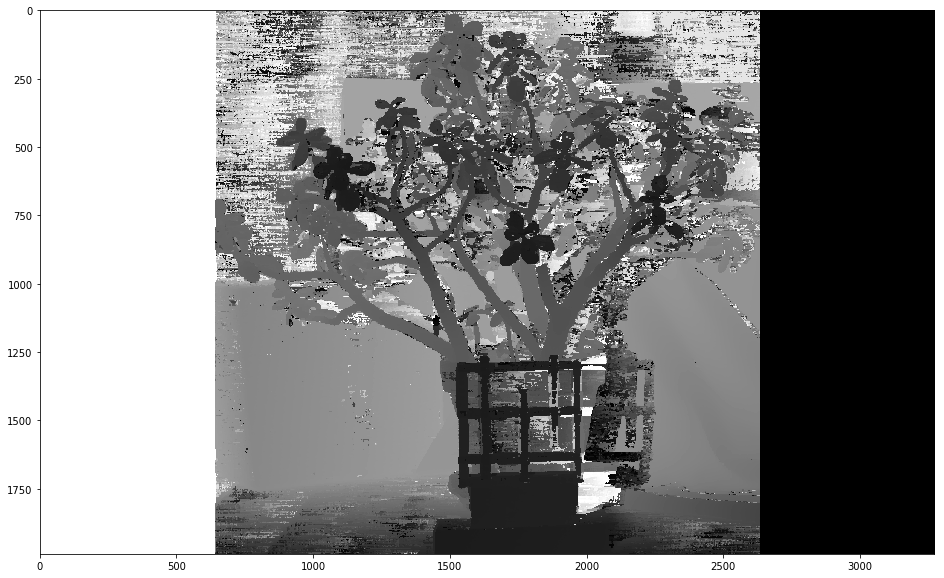

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(dispr,'gray')
plt.show()

In [11]:
##FILTER Parameters
# lmbda = 80000
# sigma = 1.2

# ### playtable
# lmbda = 160000
# sigma = 1.8

# # jadeplant
# lmbda = 40000
# sigma = 1.0
lmbda = 4000
sigma = 1.2



#############


wls_filter = cv.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

In [12]:
filteredImg = wls_filter.filter(displ, imgL, None, dispr)
filteredImg = filteredImg/16

In [13]:
# filteredImg = cv.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=22, norm_type=cv.NORM_MINMAX);
# filteredImg = np.uint8(filteredImg)

### removes padded columns

In [14]:
filteredImg = filteredImg[:,640:]

def relu(m):
    m[m < 0] = 0

relu(filteredImg)

filteredImg

array([[  0.    ,   0.    ,   0.    , ...,  56.6875,  56.6875,  56.75  ],
       [  0.    ,   0.    ,   0.    , ...,  56.6875,  56.6875,  56.75  ],
       [  0.    ,   0.    ,   0.    , ...,  56.6875,  56.6875,  56.75  ],
       ...,
       [252.6875, 252.6875, 252.625 , ...,  25.9375,  24.0625,  23.5625],
       [252.6875, 252.6875, 252.6875, ...,  25.9375,  24.0625,  23.5625],
       [252.6875, 252.6875, 252.6875, ...,  25.875 ,  24.0625,  23.5625]])

In [15]:
filteredImg.min(), filteredImg.max()

(0.0, 583.0625)

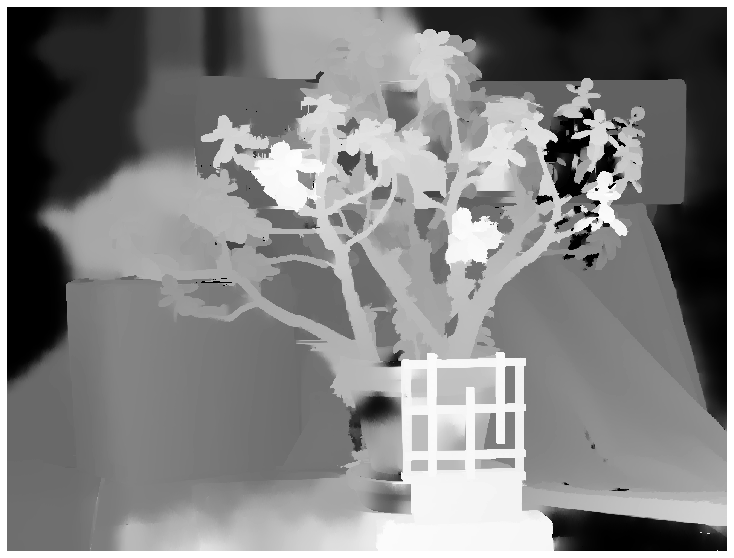

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.axis('off')


# gray = cm.gray
# m = cm.ScalarMappable(cmap=gray)
# m.set_array([filteredImg.min(),filteredImg.max()])
# plt.colorbar(m, ax=ax)

plt.imshow(filteredImg, 'gray')
plt.show()

In [17]:
cv.imwrite("data/disparidade.pgm",filteredImg)

True

### Compares with ground truth

In [18]:
ground_truth = cv.imread('data/Middlebury/Jadeplant-perfect/disp0.pfm',-1)

ground_truth[ground_truth==np.inf] = 0
ground_truth = ground_truth / 256
ground_truth

array([[ 85.87306 ,  85.89601 ,  85.86038 , ...,  59.766926,  59.741573,
         59.732304],
       [ 85.86473 ,  85.88318 ,  85.87455 , ...,  59.750877,  59.74872 ,
         59.738777],
       [ 85.860504,  85.89172 ,  85.872604, ...,  59.732273,  59.718838,
         59.713306],
       ...,
       [ 71.59159 ,  71.5677  ,  71.53706 , ..., 569.8861  , 569.89557 ,
        569.9073  ],
       [ 71.519585,  71.51202 ,  71.48655 , ..., 570.7536  , 570.7951  ,
        570.8468  ],
       [ 71.3995  ,  71.39409 ,  71.37299 , ..., 571.83057 , 571.88446 ,
        571.9433  ]], dtype=float32)

In [19]:
ground_truth.min(), ground_truth.max()

(0.0, 580.9942)

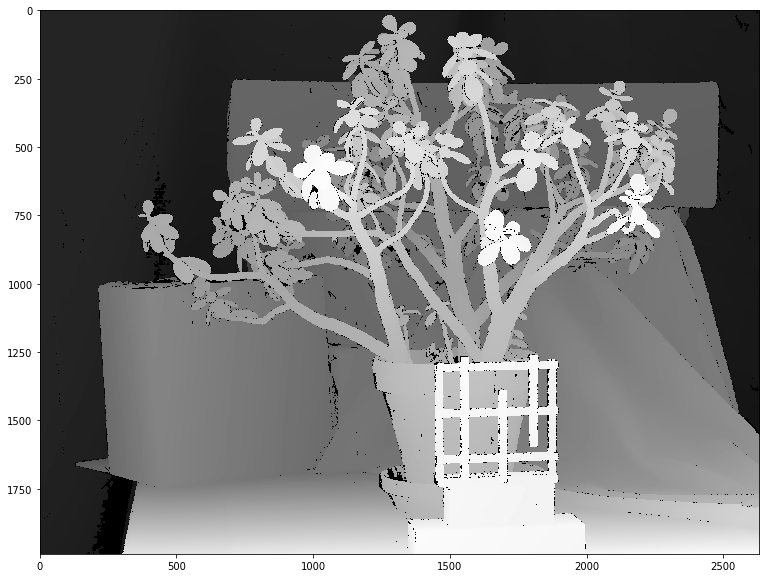

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.imshow(ground_truth, 'gray')
plt.show()

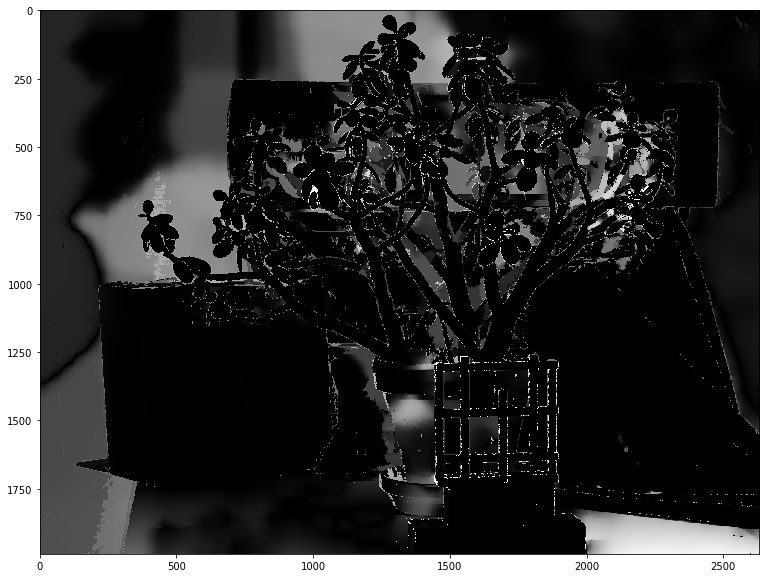

In [21]:
# ## scale the images first:
# filteredImg = cv.normalize(filteredImg, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
# ground_truth = cv.normalize(ground_truth, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

diff = np.abs(filteredImg - ground_truth)

fig, ax = plt.subplots(figsize=(20, 10))

plt.imshow(diff, 'gray')
plt.show()

### Computes bad2.0

In [22]:
total_pixels = imgL.shape[0] * imgL.shape[1]
bad2 = np.count_nonzero(diff > 2) / total_pixels
bad2

0.4915772138946146

### Make depth map

In [23]:
# filteredImg = wls_filter.filter(displ, imgL, None, dispr)

In [24]:
# ### dividir por 16 pela saída do WLS
# filteredImg = filteredImg/16
# filteredImg

In [25]:
# def relu(m):
#     m[m < 0] = 0

# #relu(filteredImg)
# np.abs(filteredImg)
# #filteredImg

In [26]:
# filteredImg = filteredImg + 1

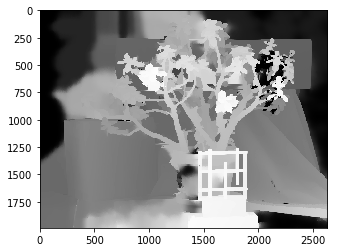

In [27]:
plt.imshow(filteredImg, 'gray')
plt.show()

In [28]:
# Z = baseline * f / (d + doffs)
filteredImg_2 = filteredImg + 100.279
filteredImg_2 = 193.006 * 2329.558 / filteredImg_2
# filteredImg_2 = filteredImg_2/1000

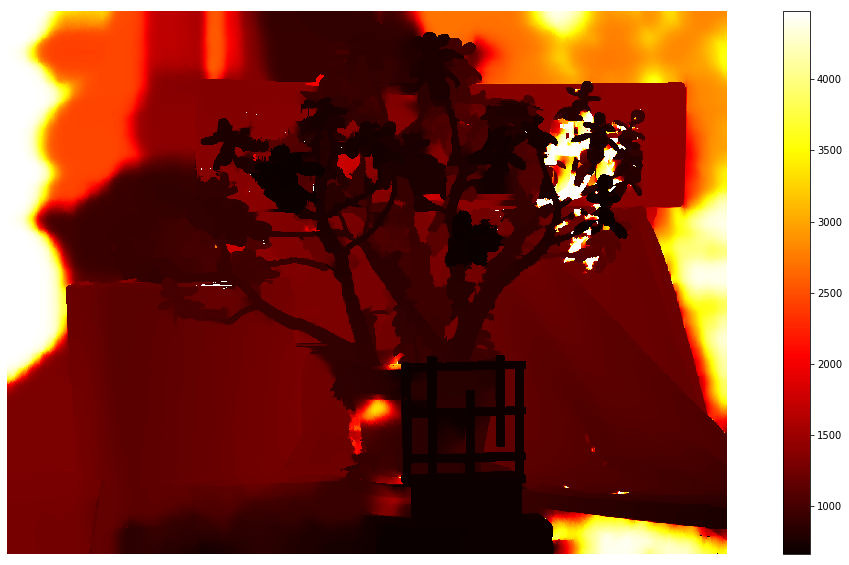

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.axis('off')

#filteredImg_2 = cv.normalize(src=filteredImg_2, dst=filteredImg_2, beta=0, alpha=254, norm_type=cv.NORM_MINMAX);
#filteredImg_2 = np.uint8(filteredImg_2)

hot = cm.hot
m = cm.ScalarMappable(cmap=hot)
m.set_array([filteredImg_2.min(),filteredImg_2.max()])
plt.colorbar(m, ax=ax)

plt.imshow(filteredImg_2, 'hot')
plt.show()

In [52]:
#############
#usar esses params pra obter um numero pequeno de lambda

f = 7315.238
doffs = 809.195

x = f * doffs
large = x ** -1
#print(np.log( x))
round(large,7)

2e-07

In [45]:
f = 2329.558
doffs = 100.279

x = f * doffs

small = x ** -1
#print(np.log( x))
round(small,7)

4.3e-06

In [35]:
small / large

25.33950511700366

In [33]:
large * 10000000

1.689344993194623

In [34]:
small * 10000000

42.80716609943966

In [38]:
42 * 4000

168000

In [53]:
large = large * 10000000
int(large) * 4000

4000